In [12]:
from diffusers import StableDiffusionPipeline
import torch

from pathlib import Path
from torchvision.io import read_image
from torchvision import transforms

from tqdm import tqdm

In [13]:
# Load the pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to("cuda")

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 21.84it/s]


In [14]:
pipe.vae.config.scaling_factor

0.18215

In [ ]:
save_folder = Path("../images/training_images_latents")

image_paths = list(Path("../images/training_images").glob("*/*.jpg"))

img_transform = transforms.Resize((512, 512))
for image_path in tqdm(image_paths):
    image = img_transform(read_image(image_path)) / 127.5 - 1 # Normalize to [-1, 1]
    image = image.to("cuda")
    image = image.unsqueeze(0)

    with torch.no_grad():
        latents = (pipe.vae.config.scaling_factor * pipe.vae.encode(image).latent_dist.mean).cpu().detach()

    image_name = image_path.name
    image_class = image_path.parent.name

    save_path = save_folder / image_class / image_name.replace(".jpg", ".pt")
    save_path.parent.mkdir(parents=True, exist_ok=True)

    torch.save(latents, save_path)
    

100%|██████████| 16540/16540 [14:03<00:00, 19.61it/s]


torch.Size([1, 3, 512, 512])


/tmp/ipykernel_89963/3599285655.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoded = pipe.vae.decode(torch.load("/home/igragon/Projects/innopolis_thesis_2025/datase

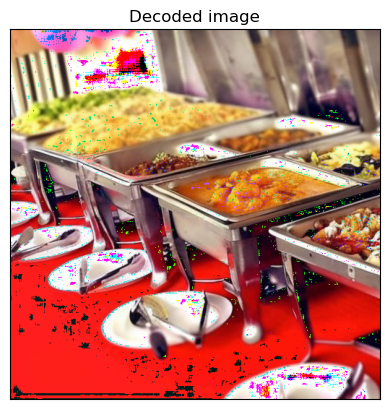

In [21]:
with torch.no_grad():
    decoded = pipe.vae.decode(torch.load("/home/igragon/Projects/innopolis_thesis_2025/datasets/Things-EEG-2/images/training_images_latents/00189_buffet/buffet_05s.pt").to("cuda") / pipe.vae.config.scaling_factor).sample
    print(decoded.shape)
    import matplotlib.pyplot as plt
    import numpy as np
    plt.imshow(np.uint8((decoded[0].permute(1, 2, 0).cpu().numpy() + 1) * 127.5))
    plt.title("Decoded image")
    plt.xticks([])
    plt.yticks([])
    plt.show()

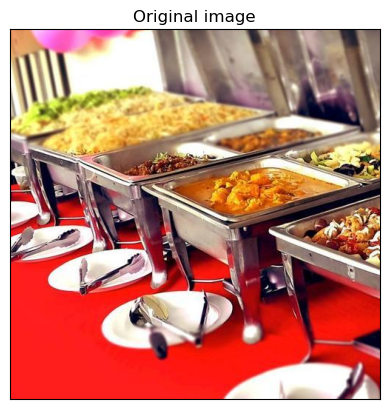

In [22]:

plt.imshow(read_image("/home/igragon/Projects/innopolis_thesis_2025/datasets/Things-EEG-2/images/training_images/00189_buffet/buffet_05s.jpg").permute(1, 2, 0).cpu().numpy())
plt.title("Original image")
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
# good